work on:

X cooling schedule (exponential decay)

X odeint

X accept 98% (only for present settings)

determine right samplingspace

X randomly change one or more variables


Can we not get stuck in a local minimum by changing one parameter at a time? see picture '2dLocalMinima'

Annealing temperature:

A good rule of thumb is that your initial temperature Tmax should be set to accept roughly 98% of the moves 
and that the final temperature Tmin should be low enough that the solution does not improve much, if at all.

The number of steps can influence the results; 
if there are not enough iterations to adequately explore the search space it can get trapped at a local minimum.

steven said a samplingspace of 2 should work

e^-verschil/T

is el[0] goed?

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// from https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling
// disable scroll

<IPython.core.display.Javascript object>

In [17]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
import math
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error as detMSE
from scipy.integrate import odeint
#from scipy.spatial import distance

In [48]:
# set temperatures
def temperature(Tmax,t,amountOfTemperatures):
    x = (math.log(1./Tmax))/amountOfTemperatures
    T = Tmax * math.exp(t*x)
    return T
"""
old:
def temperature(TMax,time):
    T = TMax * np.e**(-1./(TMax / 10.)*time)
    return T
"""

# differential equation for prey
def dx(alfa, x, beta, y):
    dx = alfa * x - beta * x * y
    return dx

# differential equation for predators
def dy(delta, x, y, gamma):
    dy = delta * x * y - gamma * y
    return dy

# solving differential equations using Euler method
def EulerSolveODE(x,y,parameters, times):
    for month in times:
        xList.append(x)
        yList.append(y)    
        x += dx(parameters[0], x, parameters[1], y)
        y += dy(parameters[2], x, y, parameters[3]) 

# solving differential equations using scipy ode int         
def pend(f, t, a, b, c, d):
    x, y = f
    dfdt = [a*x - b*x*y, d*x*y - c*y]
    return dfdt        
        
# randomly change one of the parameters 
# all change at equal probability
# the parameter is changed to a completely new number in the range
def changeParameter(parameters, samplingSpace):
    randomNumber = np.random.random()
    if randomNumber < 1./4:
        parameters[0] = np.random.random()*samplingSpace
    elif randomNumber < 2./4:
        parameters[1] = np.random.random()*samplingSpace
    elif randomNumber < 3./4:
        parameters[2] = np.random.random()*samplingSpace
    else:
        parameters[3] = np.random.random()*samplingSpace
    return parameters

# randomly change parameters, 
# with p = 1./2 for each parameter to be changed 
# the parameter is changed to a completely new number in the range
def changeMultipleParameters(parameters, samplingSpace):
    change = 0
    while change == 0:
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[0] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[1] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[2] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[3] = np.random.random()*samplingSpace
            change = 1
    return parameters

In [19]:
# import csv using pandas
# create 3 data lists: time, prey and predators
pandaFile = pandas.read_csv('predator-prey-data.csv')
times = []
xValues = []
yValues = []
for row in range(len(pandaFile['t'])):
    time = pandaFile['t'][row]
    x = pandaFile['x'][row]
    y = pandaFile['y'][row]
    times.append(time)
    xValues.append(x)
    yValues.append(y)

In [98]:
def optimize_fit(Calculations,MarkovLength,Tolerant,Lowest,xValues,yValues):
    """
    
    """
    # are these still used
    # set the initial amount of prey and predators equal to those of the real data
    x = xValues[0] #amount of prey
    y = yValues[0] #amount of predators

    # set the sampling space from where to pick the parameters in the domain [0,samplingSpace]
    samplingSpace = 10

    # assign a random number to the parameters in the range
    alfa = np.random.random()*samplingSpace #birth rate prey
    beta = np.random.random()*samplingSpace #prey catch rate
    delta = np.random.random()*samplingSpace #birth of predators per predator per prey
    gamma = np.random.random()*samplingSpace #death rate predators
    establishedParameters = [alfa,beta,delta,gamma]

    # assign the cooling schedule
    TMax = 20000 # proper starting temperature for samplingspace = 0.1
    amountOfTemperatures = Calculations/MarkovLength
    temperatures = []
    for t in range(amountOfTemperatures):
        T = temperature(TMax,t,amountOfTemperatures)
        temperatures.append(T)    

    # assign a high number to the mean squared error 
    #hoping the first random guess of the parameters will lead to acceptance
    mse = 999999999

    # track how often new values are assigned
    trackAcceptance = [0,0]
    #MSEDifferencePerT = []

    # simulating annealing
    temperatureTrack = []
    for T in temperatures:
        listParameters = []
        listMSE = []
        for chainPosition in range(MarkovLength):
            temperatureTrack.append(T)
            listParameters.append(establishedParameters)
            listMSE.append(mse)
            
            # set newParameters almost equal to establisedParameters
            newParameters = changeMultipleParameters(establishedParameters, samplingSpace)
            
            # using scipy odeint
            # calculate the amount of prey and predators for each time point indicated from data
            # assume all time point lie at equal distance
            
            y0 = [xValues[0], yValues[0]]
            
            sol = odeint(pend, y0, times, args=tuple(newParameters))
            #print 'sol =', sol
            #print '[el[0] for el in sol] =', [el[0] for el in sol]
            #print '[el[1] for el in sol] =', [el[1] for el in sol]
            
            #determine mse of prey and predators
            msePrey = detMSE(xValues, [el[0] for el in sol])
            msePredators = detMSE(yValues, [el[1] for el in sol])
            mseSum = msePrey + msePredators
            
            # if the new mean squared error is smaller than the old, 
            # accept newParameters as establisedParameters
            # take the lower mean squared error as the new benchmark
            if mseSum < mse:
                establishedParameters = newParameters
                mse = mseSum
                
                trackAcceptance[0] += 1
                    
            # if the new mean squared error is almost as small as the old,
            # accept newParameters as establisedParameters 
            # take the lower mean squared error as the new benchmark
            elif math.exp(-(mseSum - mse)/T) < np.random.random() and Tolerant == 'T':
                #print 'Tolerant = T'
                establishedParameters = newParameters
                mse = mseSum 
                
                trackAcceptance[1] += 1
                # track the score difference
                #MSEDifferencePerT.append(mseSum - mse)
        
        # choose the lowest parameters found in the Markov chain for the next temperature, or not
        if Lowest == 'T':
            #print 'Lowest = T'
            PositionMinimalMSE = listMSE.index(min(listMSE))
            establishedParameters = listParameters[PositionMinimalMSE]
    
    preyQuantity = [el[0] for el in sol]
    predatorQuantity = [el[1] for el in sol]
    return [establishedParameters, temperatureTrack, trackAcceptance, [preyQuantity,predatorQuantity]]

# xValues,yValues is wrong

In [65]:
Calculations = 10
MarkovLength = 5
Tolerant = 'T'
Lowest = 'F'
establishedParameters, temperatureTrack, trackAcceptance = optimize_fit(Calculations,MarkovLength,Tolerant,Lowest,xValues,yValues)
print establishedParameters
print temperatureTrack
print trackAcceptance

[9.719858405233104, 7.825946577700831, 4.094928016519179, 2.5097368022175504]
[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, 141.42135623730957, 141.42135623730957, 141.42135623730957, 141.42135623730957, 141.42135623730957]
[4, 1]

100


In [99]:
#establishedParameters, temperatureTrack, trackAcceptance, [xValues,yValues] = 
#optimize_fit(Calculations,MarkovLength,Tolerant,Lowest,xValues,yValues)
Calculations = 1000

MarkovTolerantLowest = optimize_fit(Calculations,100,'T','T',xValues,yValues)
ContinuousTolerant = optimize_fit(Calculations,1,'T','F',xValues,yValues)
MarkovIntolerant = optimize_fit(Calculations,100,'F','F',xValues,yValues)

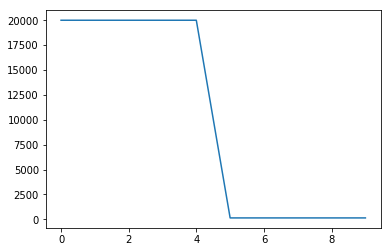

In [62]:
# show the temperature shows exponential decay
plt.plot(temperatureTrack)
plt.show()

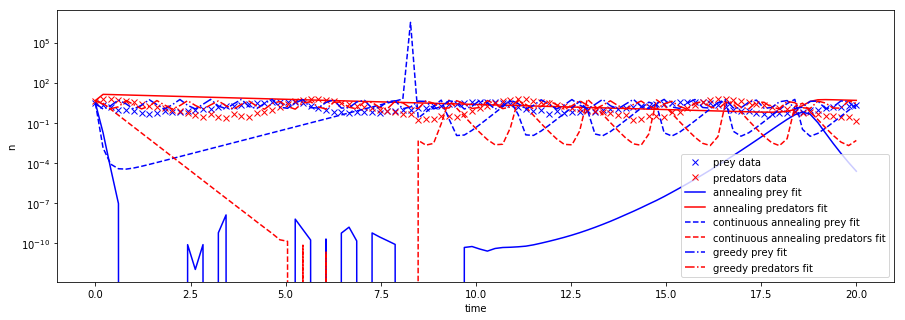

In [100]:
plt.figure(figsize=(15,5))

# plot the data
plt.plot(times,xValues,'x', label = 'prey data', color = 'b')
plt.plot(times,yValues,'x', label = 'predators data', color = 'r')

# plot various fitting options
plt.plot(times,MarkovTolerantLowest[3][0],label = 'annealing prey fit',color = 'b')
plt.plot(times,MarkovTolerantLowest[3][1],label = 'annealing predators fit',color = 'r')
plt.plot(times,ContinuousTolerant[3][0],label = 'continuous annealing prey fit',ls='dashed',color = 'b')
plt.plot(times,ContinuousTolerant[3][1],label = 'continuous annealing predators fit',ls='dashed',color = 'r')
plt.plot(times,MarkovIntolerant[3][0],label = 'greedy prey fit',ls='dashdot',color = 'b')
plt.plot(times,MarkovIntolerant[3][1],label = 'greedy predators fit',ls='dashdot',color = 'r')

plt.yscale("log")
plt.xlabel('time')
plt.ylabel('n')
plt.legend()
plt.show()